# Hadoop & Spark Setup

In [ ]:
"""
~/.bashrc

##### JAVA CONFIGURATION #####
export JAVA_HOME="/usr/lib/jvm/java-11-openjdk-amd64"
export PATH=$JAVA_HOME/bin:$PATH

##### HADOOP CONFIGURATION #####
export HADOOP_HOME=/usr/local/hadoop
export HADOOP_COMMON_HOME=$HADOOP_HOME
export HADOOP_HDFS_HOME=$HADOOP_HOME
export HADOOP_MAPRED_HOME=$HADOOP_HOME
export YARN_HOME=$HADOOP_HOME
export HADOOP_CONF_DIR=$HADOOP_HOME/etc/hadoop

# Native libraries
export HADOOP_COMMON_LIB_NATIVE_DIR=$HADOOP_HOME/lib/native
export HADOOP_OPTS="-Djava.library.path=$HADOOP_HOME/lib/native"
export LD_LIBRARY_PATH=$HADOOP_HOME/lib/native:$LD_LIBRARY_PATH

# Hadoop classpath
export CLASSPATH=$($HADOOP_HOME/bin/hadoop classpath --glob):$CLASSPATH

# Add Hadoop to PATH
export PATH=$HADOOP_HOME/bin:$HADOOP_HOME/sbin:$PATH

##### SPARK CONFIGURATION #####
export SPARK_HOME=/usr/local/spark
export PATH=$SPARK_HOME/bin:$PATH

##### ANACONDA CONFIGURATION #####
export PATH="$PATH:/home/hduser/.local/bin"

# >>> conda initialize >>>
# !! Contents within this block are managed by 'conda init' !!
__conda_setup="$('/usr/local/anaconda3/bin/conda' 'shell.bash' 'hook' 2> /dev/null)"
if [ $? -eq 0 ]; then
    eval "$__conda_setup"
else
    if [ -f "/usr/local/anaconda3/etc/profile.d/conda.sh" ]; then
        . "/usr/local/anaconda3/etc/profile.d/conda.sh"
    else
        export PATH="/usr/local/anaconda3/bin:$PATH"
    fi
fi
unset __conda_setup
# <<< conda initialize <<<

"""

In [ ]:
"""
**Start Hadoop**
start-dfs.sh

**Start Standalone Cluster**
$SPARK_HOME/sbin/start-master.sh
$SPARK_HOME/sbin/start-worker.sh -c 4 -m 4g spark://BDSPVM2025S2:7077

**Start History Server**
$SPARK_HOME/sbin/start-history-server.sh

** Start pyspark **
export PYSPARK_PYTHON="/home/hduser/.conda/envs/tf-spark-env/bin/python3.10"
export PYSPARK_DRIVER_PYTHON="/usr/local/anaconda3/bin/jupyter"
export PYSPARK_DRIVER_PYTHON_OPTS="lab"

pyspark --master spark://BDSPVM2025S2:7077 \
    --name "CIFAR_1SLOT" \
    --conf spark.executor.memory=2g \
    --conf spark.executor.cores=2 \
    --conf spark.cores.max=2 \
    --conf spark.eventLog.enabled=true \
    --conf spark.eventLog.dir=hdfs:///spark-logs

pyspark --master spark://BDSPVM2025S2:7077 \
    --name "CIFAR_2SLOT" \
    --conf spark.executor.memory=2g \
    --conf spark.executor.cores=2 \
    --conf spark.cores.max=4 \
    --conf spark.eventLog.enabled=true \
    --conf spark.eventLog.dir=hdfs:///spark-logs
    
**Stop Standalone Cluster**
$SPARK_HOME/sbin/stop-worker.sh
$SPARK_HOME/sbin/stop-master.sh

**Stop History Server**
$SPARK_HOME/sbin/stop-history-server.sh

**Stop Hadoop**
stop-dfs.sh
"""

# Import Libraries

In [1]:
# Python
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots
import seaborn as sns
import json,os,time

# Spark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as F
from spark_tensorflow_distributor import MirroredStrategyRunner

# DL
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras import layers, models, Input

2025-03-30 12:05:15.966740: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-30 12:05:16.546295: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-30 12:05:16.552097: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-30 12:05:18.082793: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("TensorFlow Version:", tf.__version__)
print("TensorFlow I/O Version:", tfio.__version__)
print("Registered File Systems:", tf.io.gfile.get_registered_schemes())

TensorFlow Version: 2.13.1
TensorFlow I/O Version: 0.37.1
Registered File Systems: ['har', 's3', 'viewfs', 'https', 'http', 'oss', 'hdfs', 'az', 'ram', 'file', '', 'gs']


In [3]:
# Conf
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

plt.style.use(['science','no-latex','light'])

# Data Collection

## Downloading python version for testing

In [4]:
!pwd

/home/hduser/Desktop/CA


In [5]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O Data/cifar-10-python.tar.gz

--2025-03-30 12:12:15--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘Data/cifar-10-python.tar.gz’

Data/cifar-10-pytho 100%[===================>] 162.60M  16.9MB/s    in 9.8s    

2025-03-30 12:12:25 (16.6 MB/s) - ‘Data/cifar-10-python.tar.gz’ saved [170498071/170498071]



In [6]:
!tar -xvzf Data/cifar-10-python.tar.gz -C Data

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [7]:
!rm Data/cifar-10-python.tar.gz

## Downloading binary version for spark

In [8]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz -O Data/cifar-10-binary.tar.gz

--2025-03-30 12:12:32--  https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170052171 (162M) [application/x-gzip]
Saving to: ‘Data/cifar-10-binary.tar.gz’

Data/cifar-10-binar 100%[===================>] 162.17M  18.4MB/s    in 8.6s    

2025-03-30 12:12:41 (18.8 MB/s) - ‘Data/cifar-10-binary.tar.gz’ saved [170052171/170052171]



In [9]:
!tar -xvzf Data/cifar-10-binary.tar.gz -C Data

cifar-10-batches-bin/
cifar-10-batches-bin/data_batch_1.bin
cifar-10-batches-bin/batches.meta.txt
cifar-10-batches-bin/data_batch_3.bin
cifar-10-batches-bin/data_batch_4.bin
cifar-10-batches-bin/test_batch.bin
cifar-10-batches-bin/readme.html
cifar-10-batches-bin/data_batch_5.bin
cifar-10-batches-bin/data_batch_2.bin


In [10]:
!rm Data/cifar-10-binary.tar.gz

# Data Ingestion (Upload to HDFS)

In [11]:
# Create HDFS Directory Structure
!hdfs dfs -mkdir -p /cifar10/raw/train
!hdfs dfs -mkdir -p /cifar10/raw/test
!hdfs dfs -mkdir -p /cifar10/raw/meta

In [12]:
# Upload training batches
!hdfs dfs -put Data/cifar-10-batches-bin/data_batch_* /cifar10/raw/train/

In [13]:
# Upload test batch
!hdfs dfs -put Data/cifar-10-batches-bin/test_batch.bin /cifar10/raw/test/

In [14]:
# Upload metadata
!hdfs dfs -put Data/cifar-10-batches-bin/batches.meta.txt /cifar10/raw/meta/
!hdfs dfs -put Data/cifar-10-batches-bin/readme.html /cifar10/raw/meta/

In [15]:
!hdfs dfs -ls -R /cifar10/

drwxr-xr-x   - hduser supergroup          0 2025-03-17 21:55 /cifar10/logs
drwxr-xr-x   - hduser supergroup          0 2025-03-18 09:40 /cifar10/logs/cifar
-rw-r--r--   1 hduser supergroup       1813 2025-03-18 00:53 /cifar10/logs/cifar/history_1slot.json
-rw-r--r--   1 hduser supergroup       2038 2025-03-17 21:55 /cifar10/logs/cifar/history_2slot.json
-rw-r--r--   1 hduser supergroup         36 2025-03-18 00:53 /cifar10/logs/cifar/training_time_1slot.json
-rw-r--r--   1 hduser supergroup         27 2025-03-18 09:40 /cifar10/logs/cifar/training_time_2slot.json
drwxr-xr-x   - hduser supergroup          0 2025-03-16 18:19 /cifar10/logs/mnist
-rw-r--r--   1 hduser supergroup        794 2025-03-16 18:03 /cifar10/logs/mnist/history_1slot.json
-rw-r--r--   1 hduser supergroup        875 2025-03-16 18:19 /cifar10/logs/mnist/history_2slot.json
drwxr-xr-x   - hduser supergroup          0 2025-03-17 21:55 /cifar10/model
drwxr-xr-x   - hduser supergroup          0 2025-03-18 00:53 /cifar10/model

In [16]:
print("Training Batch Count:")
!hdfs dfs -ls /cifar10/raw/train | grep data_batch | wc -l

Training Batch Count:
5


In [17]:
print("Test Batch Count:")
!hdfs dfs -ls /cifar10/raw/test | grep test_batch | wc -l

Test Batch Count:
1


In [18]:
print("File Size Check:")
!hdfs dfs -du -h /cifar10/raw/

File Size Check:
149      149      /cifar10/raw/meta
29.3 M   29.3 M   /cifar10/raw/test
146.5 M  146.5 M  /cifar10/raw/train


## Verify files

In [19]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [20]:
filename='Data/cifar-10-batches-py/data_batch_1'

data_batch_1 = unpickle(filename)

In [21]:
meta_path = 'Data/cifar-10-batches-py/batches.meta'
meta = unpickle(meta_path)
class_names = [x.decode('utf-8') for x in meta[b'label_names']]
print("Class Names:", class_names)

Class Names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [22]:
def inspect_batch(batch_path):
    batch = unpickle(batch_path)
    return {
        'num_samples': len(batch[b'labels']),
        'image_shape': batch[b'data'][0].shape,
        'classes': set(batch[b'labels'])
    }

In [23]:
inspect_batch('Data/cifar-10-batches-py/data_batch_1')

{'num_samples': 10000,
 'image_shape': (3072,),
 'classes': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}}

In [24]:
inspect_batch('Data/cifar-10-batches-py/data_batch_2')

{'num_samples': 10000,
 'image_shape': (3072,),
 'classes': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}}

In [25]:
inspect_batch('Data/cifar-10-batches-py/data_batch_3')

{'num_samples': 10000,
 'image_shape': (3072,),
 'classes': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}}

In [26]:
inspect_batch('Data/cifar-10-batches-py/data_batch_4')

{'num_samples': 10000,
 'image_shape': (3072,),
 'classes': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}}

In [27]:
inspect_batch('Data/cifar-10-batches-py/data_batch_5')

{'num_samples': 10000,
 'image_shape': (3072,),
 'classes': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}}

# EDA in Spark

Sampling is essential for exploratory data analysis (EDA) in Spark, as full dataset collection can cause Out of Memory (OOM) errors. Many EDA tasks, like visualizing distributions and computing statistics, require bringing data to the driver. By sampling a subset, we can approximate distributions, detect trends, and identify anomalies efficiently without overwhelming system resources.

In [13]:
train_path = "hdfs:///cifar10/raw/train/data_batch_*.bin"
test_path = "hdfs:///cifar10/raw/test/test_batch.bin"

rdd_train_raw = spark.sparkContext.binaryFiles(train_path)
rdd_test_raw = spark.sparkContext.binaryFiles(test_path)

CIFAR-10 binary files consist of 3073-byte records, where each record represents a single image. The first byte is the label (0–9, corresponding to the class), followed by 3072 bytes of pixel data (1024 bytes per channel for R, G, and B). Spark reads these files using binaryFiles(), loading each file as a (filename, bytes) pair. To interpret the structure of the binary records, we need to define a custom parsing function that extracts each 3073-byte record, splits it into label and pixel values, and converts the pixel data into numerical arrays.

## Visual inspection
Visually inspecting a small collection of images allows us to confirm that the parsing is correct, spot-check image quality (e.g., resolution, color channels, potential corruption), and ensure labels make sense. This is particularly important in a distributed setup, where you might parse or transform large files at scale and only check a tiny portion locally for verification.

In [14]:
def parse_full_image(file_and_data):
    """
    Yields (label, image_array) for each image.
    image_array will be shape (32, 32, 3).
    We do NOT want to collect all 50k images in memory, so we'll sample.
    """
    filename, data = file_and_data
    record_size = 3073
    num_images = len(data) // record_size

    for i in range(num_images):
        offset = i * record_size
        record = data[offset:offset+record_size]
        label = record[0]
        # pixel bytes
        pixel_data = record[1:]
        
        # Convert pixel_data into 3 channels
        # R: bytes [0:1024], G: [1024:2048], B: [2048:3072]
        R = pixel_data[:1024]
        G = pixel_data[1024:2048]
        B = pixel_data[2048:]
        
        R_mat = np.frombuffer(R, dtype=np.uint8).reshape((32, 32))
        G_mat = np.frombuffer(G, dtype=np.uint8).reshape((32, 32))
        B_mat = np.frombuffer(B, dtype=np.uint8).reshape((32, 32))
        
        image = np.dstack([R_mat, G_mat, B_mat])  # shape (32,32,3)
        yield (int(label), image)

In [15]:
# We'll do sampling on train set only, e.g. 0.002 fraction => ~100 samples
fraction = 0.002
rdd_sample = rdd_train_raw.flatMap(parse_full_image).sample(False, fraction, seed=42)
sample_data = rdd_sample.collect()
sample_data

[(0,
  array([[[230, 230, 230],
          [228, 228, 228],
          [227, 227, 227],
          ...,
          [221, 221, 221],
          [221, 221, 221],
          [221, 221, 221]],
  
         [[229, 229, 229],
          [227, 227, 227],
          [227, 227, 227],
          ...,
          [221, 221, 221],
          [219, 219, 219],
          [219, 219, 219]],
  
         [[227, 227, 227],
          [227, 227, 227],
          [226, 226, 226],
          ...,
          [222, 222, 222],
          [222, 222, 222],
          [222, 222, 222]],
  
         ...,
  
         [[136, 136, 136],
          [131, 131, 131],
          [124, 124, 124],
          ...,
          [ 95,  95,  95],
          [ 95,  95,  95],
          [ 99,  99,  99]],
  
         [[131, 131, 131],
          [127, 127, 127],
          [120, 120, 120],
          ...,
          [ 94,  94,  94],
          [ 93,  93,  93],
          [ 94,  94,  94]],
  
         [[132, 132, 132],
          [127, 127, 127],
          [121, 121

In [16]:
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


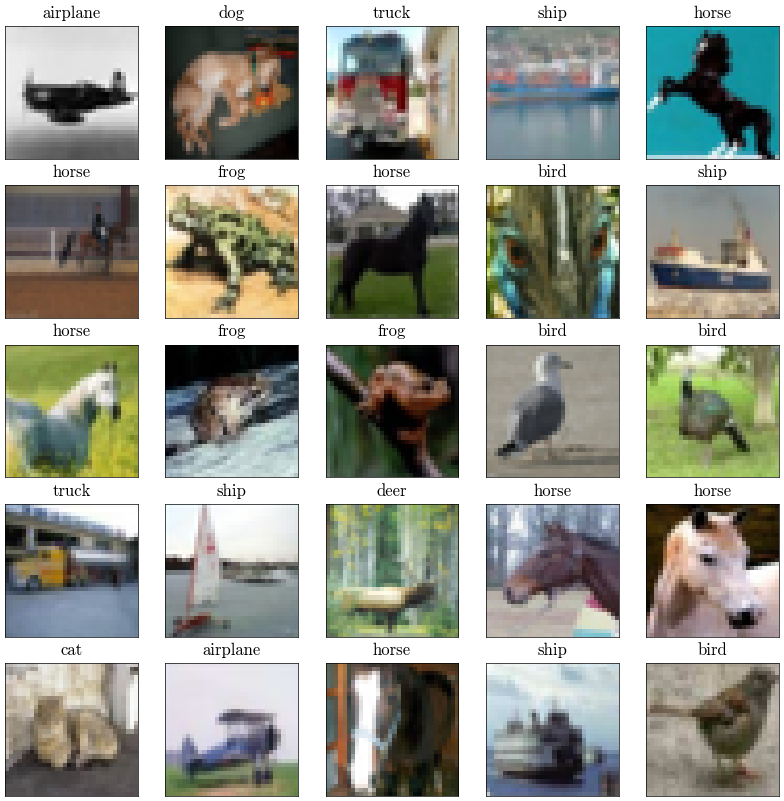

In [17]:
plt.figure(figsize=(10,10))
num_to_show = min(len(sample_data), 25)

for i in range(num_to_show):
    label, img = sample_data[i]
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img)
    plt.title(class_names[label])
plt.show()

Visual inspection of a small set of images confirms proper parsing—images display recognizable objects, and labels correspond sensibly to the content (e.g., “airplane,” “dog,” “frog,” etc.).

## Label distribution
This step shows how many images belong to each category, giving a sense of whether the dataset is balanced or skewed. It’s important to verify each class is adequately represented before doing any model training or further analysis, because significant imbalance can bias models and affect overall performance.

In [18]:
def parse_labels_only(file_and_data):
    """
    Yields (label, 1) for each image in a CIFAR-10 binary file,
    ignoring the pixel data to keep memory usage low.
    """
    filename, data = file_and_data
    record_size = 3073  # 1 label byte + 3072 pixel bytes
    num_images = len(data) // record_size
    
    for i in range(num_images):
        offset = i * record_size
        label = data[offset]  # first byte is label
        yield (int(label), 1)

In [19]:
# Parse for both train and test
rdd_label_train = rdd_train_raw.flatMap(parse_labels_only)
rdd_label_test = rdd_test_raw.flatMap(parse_labels_only)

# Count by label using reduceByKey
rdd_label_counts_train = rdd_label_train.reduceByKey(lambda a, b: a + b)
rdd_label_counts_test = rdd_label_test.reduceByKey(lambda a, b: a + b)

# Collect train results to driver
label_counts_train  = rdd_label_counts_train.collect()
label_counts_train .sort(key=lambda x: x[0])

print("Training Set Label Distribution (label, count):")
for lbl, cnt in label_counts_train :
    print(lbl, cnt)

# Collect test results to driver
label_counts_test  = rdd_label_counts_test.collect()
label_counts_test .sort(key=lambda x: x[0])

print("\nTest Set Label Distribution (label, count):")
for lbl, cnt in label_counts_test :
    print(lbl, cnt)

Training Set Label Distribution (label, count):
0 5000
1 5000
2 5000
3 5000
4 5000
5 5000
6 5000
7 5000
8 5000
9 5000

Test Set Label Distribution (label, count):
0 1000
1 1000
2 1000
3 1000
4 1000
5 1000
6 1000
7 1000
8 1000
9 1000


Each of the ten CIFAR-10 categories (0–9) shows exactly 5000+1000 images, confirming the dataset is uniformly balanced with an equal number of samples in each class, for both training and test data. 

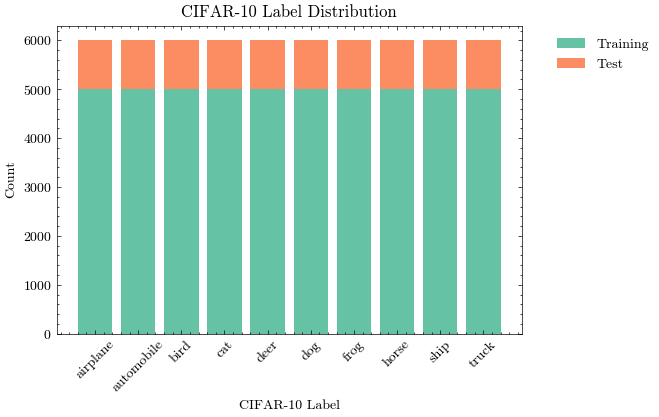

In [20]:
labels_train = [lbl for lbl, cnt in label_counts_train]
train_counts = [cnt for lbl, cnt in label_counts_train]
test_counts = [cnt for lbl, cnt in label_counts_test]

x = np.arange(len(labels_train))

cmap = plt.get_cmap('Set2')
color_train = cmap(0)
color_test = cmap(1)

plt.figure(figsize=(6, 4))
plt.bar(x, train_counts, label='Training', color=color_train)
plt.bar(x, test_counts, bottom=train_counts, label='Test', color=color_test)

plt.xlabel('CIFAR-10 Label')
plt.ylabel('Count')
plt.title('CIFAR-10 Label Distribution')
plt.xticks(x, class_names, rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Average pixel intensity
By calculating a global mean (or other statistics) of pixel values, we get a quick read on the dataset’s color/brightness properties. This can help inform normalization strategies or highlight whether some batches are drastically different (e.g., images that are too dark or bright), which could impact model training.

In [21]:
def parse_and_sum_intensity(file_and_data):
    """
    For each image, compute (sum_of_pixels, count_of_pixels) 
    so we can aggregate globally.
    """
    filename, data = file_and_data
    record_size = 3073
    num_images = len(data) // record_size

    for i in range(num_images):
        start = i * record_size
        record = data[start:start + record_size]

        # Skip label (first byte)
        pixel_data = record[1:]  # 3072 bytes
        arr = np.frombuffer(pixel_data, dtype=np.uint8)
        
        # sum_of_pixels, count_of_pixels
        yield (np.sum(arr), len(arr))

In [22]:
# Create RDD of sums
rdd_intensity_train = rdd_train_raw.flatMap(parse_and_sum_intensity)
rdd_intensity_test = rdd_test_raw.flatMap(parse_and_sum_intensity)

# Combine both
rdd_intensity_all = rdd_intensity_train.union(rdd_intensity_test)

# We want a single global sum, global count
# reduce: (sumA, countA), (sumB, countB) => (sumA+sumB, countA+countB)
def reducer(a, b):
    return (a[0] + b[0], a[1] + b[1])

global_sum, global_count = rdd_intensity_all.reduce(reducer)

global_mean = global_sum / global_count
print("Global Mean Pixel Intensity:", global_mean)

Global Mean Pixel Intensity: 120.84449672851562


The average pixel value of about 120.84 (on a 0–255 scale) suggests that overall brightness is moderately centered, neither too dark nor too bright. This indicates the dataset contains a wide range of images and lighting conditions but does not lean toward extremes in pixel intensity.

## Brightness & Contrast
Analyzing the brightness (mean pixel intensity) and contrast (pixel value spread or standard deviation) helps detect dataset biases. If certain classes or subsets of images are significantly darker, brighter, or have low contrast, the model may struggle to generalize. This can indicate issues like poor lighting conditions in real-world data, requiring contrast adjustments, histogram equalization, or augmentations to balance the dataset and prevent feature learning from being skewed.

In [24]:
rdd_all_raw = rdd_train_raw.union(rdd_test_raw)

In [25]:
def parse_brightness_contrast(file_and_data):
    """
    Yields (mean_per_image, stdev_per_image) for each CIFAR-10 record.
    We'll skip label and compute brightness & contrast from pixel_data.
    """
    filename, data = file_and_data
    record_size = 3073
    num_records = len(data) // record_size
    
    for i in range(num_records):
        start = i * record_size
        record = data[start:start+record_size]
        pixel_data = record[1:]  # skip label
        arr = np.frombuffer(pixel_data, dtype=np.uint8)

        mean_val = np.mean(arr)
        std_val = np.std(arr)
        yield (float(mean_val), float(std_val))

In [26]:
rdd_brightcontrast = rdd_all_raw.flatMap(parse_brightness_contrast)

# Sample 2% of images (about 1200 if total is 60k).
fraction = 0.02
sample_bc = rdd_brightcontrast.sample(False, fraction, seed=42)
sample_list = sample_bc.collect()

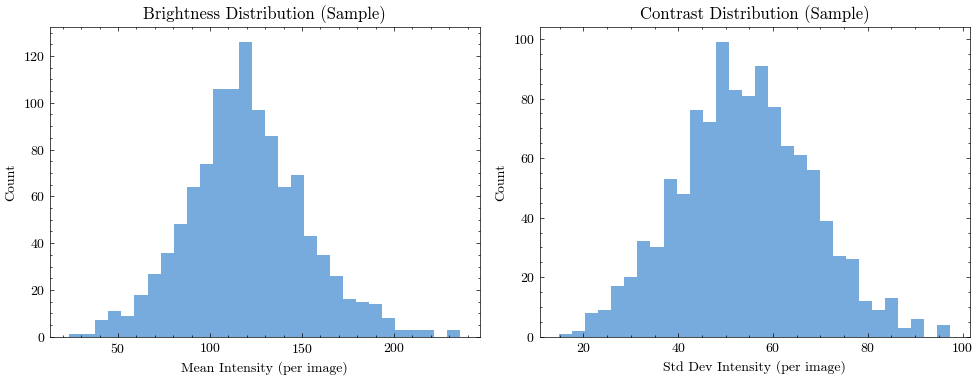

In [27]:
mean_vals = [x[0] for x in sample_list]
std_vals  = [x[1] for x in sample_list]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(mean_vals, bins=30)
plt.title("Brightness Distribution (Sample)")
plt.xlabel("Mean Intensity (per image)")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(std_vals, bins=30)
plt.title("Contrast Distribution (Sample)")
plt.xlabel("Std Dev Intensity (per image)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

The Brightness Distribution (left) shows that most images have a mean pixel intensity centered around 120–140, with a relatively symmetric spread. This suggests that the dataset contains well-balanced lighting conditions, though there are a few darker and brighter images at the extremes.

The Contrast Distribution (right) indicates that the standard deviation of pixel intensities per image is mostly concentrated around 40–60. This suggests that most images have a reasonable level of contrast, with enough variation to differentiate objects. However, a small number of images have very low contrast (below 20), which might indicate blurred or low-detail images. 

## Data Diversity
Models generalize better when trained on diverse image samples. Measuring pixel value range, variation per image, or distinct color distributions helps identify whether the dataset contains redundant, overly similar, or low-variance images. Low diversity increases the risk of overfitting, where the model memorizes patterns instead of learning useful features. Addressing this can involve data augmentation (flipping, cropping, brightness jittering) or adding more diverse training samples.

In [28]:
def parse_range(file_and_data):
    """
    Yields the min and max pixel value for each image.
    We'll measure average range as (max-min).
    """
    import numpy as np
    filename, data = file_and_data
    record_size = 3073
    num_records = len(data) // record_size

    for i in range(num_records):
        start = i * record_size
        record = data[start:start+record_size]
        arr = np.frombuffer(record[1:], dtype=np.uint8)  # skip label
        yield (arr.min(), arr.max())

In [29]:
rdd_range = rdd_all_raw.flatMap(parse_range)

fraction = 0.02
sample_range = rdd_range.sample(False, fraction, seed=42).collect()

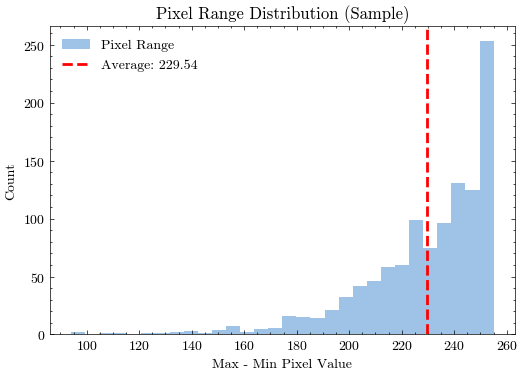

In [31]:
# Compute per-image pixel range
ranges = [mx - mn for (mn, mx) in sample_range]

avg_range = sum(ranges) / len(ranges)

plt.figure(figsize=(6,4))

plt.hist(ranges, bins=30, alpha=0.7, label="Pixel Range")


plt.axvline(avg_range, color='red', linestyle='--', linewidth=2,
            label=f'Average: {avg_range:.2f}')

plt.title("Pixel Range Distribution (Sample)")
plt.xlabel("Max - Min Pixel Value")
plt.ylabel("Count")
plt.legend()
plt.show()

The Pixel Range Distribution measures how widely pixel values are spread in each image, where higher values indicate more variation in brightness and contrast. Most images have a pixel range close to 255, meaning they use the full intensity scale from 0 (black) to 255 (white), which suggests good diversity in lighting and object textures. However, a smaller portion of images have a more limited pixel range (below 200), indicating some images may be low contrast or dominated by mid-tone colors.

# Test MNIST Dataset

## Model Setup & Utility Function

In [2]:
def build_and_compile_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28,28,1)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    return model

In [3]:
def make_datasets(batch_size, buffer_size,job_id):
    (all_images, all_labels), _ = \
        tf.keras.datasets.mnist.load_data(path=str(job_id)+'mnist.npz')
    
    train_images, train_labels = all_images[:50000], all_labels[:50000]
    val_images, val_labels = all_images[50000:59000], all_labels[50000:59000]
    
    train_ds = tf.data.Dataset.from_tensor_slices((
        tf.cast(train_images[..., tf.newaxis]/255., tf.float32),
        tf.cast(train_labels, tf.int64))
    )
    train_ds = train_ds.repeat().shuffle(buffer_size).batch(batch_size, drop_remainder=True)

    val_ds = tf.data.Dataset.from_tensor_slices((
        tf.cast(val_images[..., tf.newaxis]/255., tf.float32),
        tf.cast(val_labels, tf.int64))
    ).batch(batch_size)

    return train_ds, val_ds, len(train_images), len(val_images)

In [4]:
def _is_chief(task_type, task_id):
    return (task_type == 'worker' and task_id == 0) or task_type is None

def _get_temp_dir(dirpath, task_id):
    temp_dir = os.path.join(dirpath, f"workertemp_{task_id}")
    tf.io.gfile.makedirs(temp_dir)
    return temp_dir

def write_filepath(filepath, task_type, task_id):
    dirpath = os.path.dirname(filepath)
    base = os.path.basename(filepath)
    if not _is_chief(task_type, task_id):
        dirpath = _get_temp_dir(dirpath, task_id)
    return os.path.join(dirpath, base)

In [5]:
def copy_dir_to_hdfs(local_dir, hdfs_dir):

    tf.io.gfile.makedirs(hdfs_dir)
    
    for root, dirs, files in tf.io.gfile.walk(local_dir):
        for d in dirs:
            local_subdir_path = os.path.join(root, d)
            rel_subdir_path = os.path.relpath(local_subdir_path, local_dir)
            hdfs_subdir_path = os.path.join(hdfs_dir, rel_subdir_path)
            tf.io.gfile.makedirs(hdfs_subdir_path)

        for f in files:
            local_file_path = os.path.join(root, f)
            rel_file_path = os.path.relpath(local_file_path, local_dir)
            hdfs_file_path = os.path.join(hdfs_dir, rel_file_path)
            tf.io.gfile.copy(local_file_path, hdfs_file_path, overwrite=True)

## Distribuited training 1 slot

In [6]:
def train_mnist(batch_size):
    import tensorflow as tf
    from tensorflow.keras.callbacks import EarlyStopping
    import tensorflow_io as tfio
    import os
    import json        
    import uuid
    
    strategy = tf.distribute.MultiWorkerMirroredStrategy()
    
    with strategy.scope():

        job_id = uuid.uuid4()
        BUFFER_SIZE = 10000
 
        train_dataset, val_dataset, train_samples, val_samples = make_datasets(batch_size,BUFFER_SIZE,job_id)
        model = build_and_compile_model()
        
        steps_per_epoch = train_samples // batch_size
        early_stop = EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            mode='max',
            restore_best_weights=True
        )

        options = tf.data.Options()
        options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
        train_dataset = train_dataset.with_options(options)
        val_dataset = val_dataset.with_options(options)
        
        history = model.fit(
            train_dataset,
            epochs=10,
            steps_per_epoch=steps_per_epoch,
            validation_data=val_dataset,
            callbacks=[early_stop],
            verbose=2
        )
        
        task_type, task_id = strategy.cluster_resolver.task_type, strategy.cluster_resolver.task_id
        model_path ='tmp/keras-model'
        write_model_path = write_filepath(model_path, task_type, task_id)
        
        model.save(write_model_path)
        
        if not _is_chief(task_type, task_id):
            tf.io.gfile.rmtree(os.path.dirname(write_model_path))

        if _is_chief(task_type, task_id):
            hdfs_model_path = "hdfs:///cifar10/model/mnist/model_1slot/"
            copy_dir_to_hdfs(write_model_path, hdfs_model_path)
            
            hdfs_history_path = "hdfs:///cifar10/logs/mnist/history_1slot.json"
            with tf.io.gfile.GFile(hdfs_history_path, 'w') as f:
                json.dump(history.history, f)

In [7]:
BATCH_SIZE_PER_EXECUTOR = 16
NUM_SLOTS = 1   # 1 Spark tasks

runner = MirroredStrategyRunner(
        num_slots=NUM_SLOTS,
        local_mode=False,
        use_gpu=False,
        use_custom_strategy=True
    )
runner.run(train_mnist, batch_size = (BATCH_SIZE_PER_EXECUTOR*NUM_SLOTS))

Doing CPU training...
Will run with 1 Spark tasks.
Distributed training in progress...
View Spark executor stderr logs to inspect training...
Training with 1 slots is complete!                                              


## Distribuited training 2 slot

In [6]:
def train_mnist(batch_size):
    import tensorflow as tf
    from tensorflow.keras.callbacks import EarlyStopping
    import tensorflow_io as tfio
    import os
    import json        
    import uuid
    
    strategy = tf.distribute.MultiWorkerMirroredStrategy()
    
    with strategy.scope():

        job_id = uuid.uuid4()
        BUFFER_SIZE = 10000
 
        train_dataset, val_dataset, train_samples, val_samples = make_datasets(batch_size,BUFFER_SIZE,job_id)
        model = build_and_compile_model()
        
        steps_per_epoch = train_samples // batch_size
        early_stop = EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            mode='max',
            restore_best_weights=True
        )

        options = tf.data.Options()
        options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
        train_dataset = train_dataset.with_options(options)
        val_dataset = val_dataset.with_options(options)
        
        history = model.fit(
            train_dataset,
            epochs=10,
            steps_per_epoch=steps_per_epoch,
            validation_data=val_dataset,
            callbacks=[early_stop],
            verbose=2
        )
        
        task_type, task_id = strategy.cluster_resolver.task_type, strategy.cluster_resolver.task_id
        model_path ='tmp/keras-model'
        write_model_path = write_filepath(model_path, task_type, task_id)
        
        model.save(write_model_path)
        
        if not _is_chief(task_type, task_id):
            tf.io.gfile.rmtree(os.path.dirname(write_model_path))

        if _is_chief(task_type, task_id):
            hdfs_model_path = "hdfs:///cifar10/model/mnist/model_2slot/"
            copy_dir_to_hdfs(write_model_path, hdfs_model_path)
            
            hdfs_history_path = "hdfs:///cifar10/logs/mnist/history_2slot.json"
            with tf.io.gfile.GFile(hdfs_history_path, 'w') as f:
                json.dump(history.history, f)

In [12]:
BATCH_SIZE_PER_EXECUTOR = 16
NUM_SLOTS = 2   # 2 Spark tasks
MNIST
runner = MirroredStrategyRunner(
        num_slots=NUM_SLOTS,
        local_mode=False,
        use_gpu=False,
        use_custom_strategy=True
    )
runner.run(train_mnist, batch_size = (BATCH_SIZE_PER_EXECUTOR*NUM_SLOTS))

Doing CPU training...
Will run with 2 Spark tasks.
Distributed training in progress...
View Spark executor stderr logs to inspect training...
Training with 2 slots is complete!                                              
INFO:MirroredStrategyRunner:Training with 2 slots is complete!


## Evaluation

In [18]:
(x_test, y_test), _ = tf.keras.datasets.mnist.load_data(path='mnist.npz')
x_test, y_test = x_test[59000:], y_test[59000:]
x_test = x_test.astype("float32") / 255.0

In [19]:
def evaluate_model(model_path, history_path, model_name):
    # Load and evaluate model
    model = tf.keras.models.load_model(model_path)
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    
    # Load training history
    with tf.io.gfile.GFile(history_path, 'r') as f:
        history = json.load(f)
    
    return {
        'name': model_name,
        'model': model,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'history': history
    }

In [20]:
results = [
    evaluate_model(
        "hdfs:///cifar10/model/mnist/model_1slot/",
        "hdfs:///cifar10/logs/mnist/history_1slot.json",
        "1-Slot Model"
    ),
    evaluate_model(
        "hdfs:///cifar10/model/mnist/model_2slot/",
        "hdfs:///cifar10/logs/mnist/history_2slot.json",
        "2-Slot Model"
    )
]

In [22]:
df = pd.DataFrame({
    "Metric": ["Test Loss", "Test Accuracy"],
    "1-Slot Model": [
        results[0]["test_loss"],
        results[0]["test_accuracy"]
    ],
    "2-Slot Model": [
        results[1]["test_loss"],
        results[1]["test_accuracy"]
    ]
})

df["Difference"] = df["2-Slot Model"] - df["1-Slot Model"]

print("\nModel Comparison:\n")
print(df.to_string(index=False))


Model Comparison:

       Metric  1-Slot Model  2-Slot Model  Difference
    Test Loss      0.094571      0.118768    0.024197
Test Accuracy      0.989000      0.983000   -0.006000


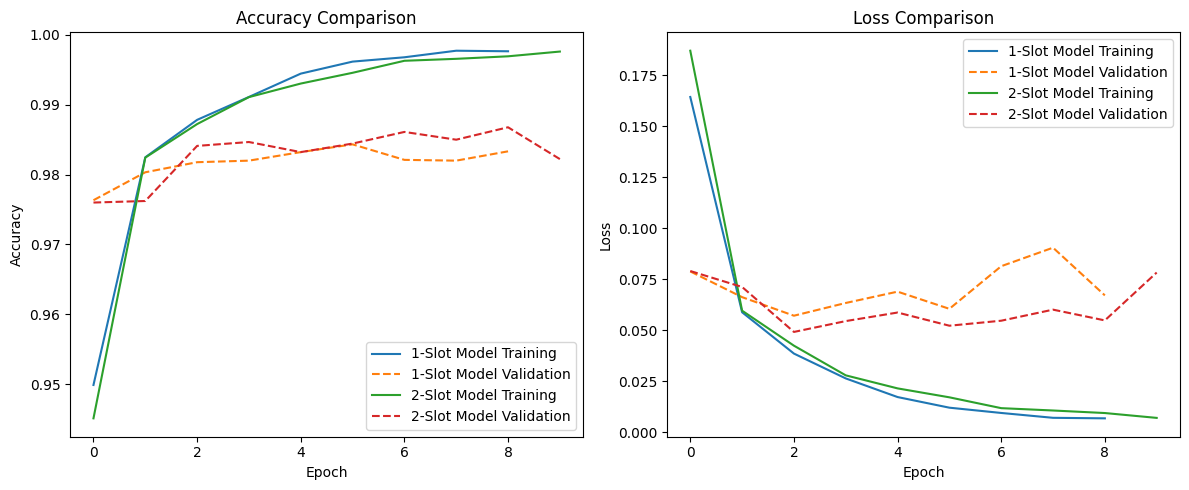

In [45]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for res in results:
    plt.plot(res['history']['accuracy'], label=f'{res["name"]} Training')
    plt.plot(res['history']['val_accuracy'], '--', label=f'{res["name"]} Validation')
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
for res in results:
    plt.plot(res['history']['loss'], label=f'{res["name"]} Training')
    plt.plot(res['history']['val_loss'], '--', label=f'{res["name"]} Validation')
plt.title('Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
for i, res in enumerate(results):
    predictions = res['model'].predict(x_test[:5])
    predicted_labels = np.argmax(predictions, axis=1)
    print(f"\n{res['name']} Predictions:")
    print("Predicted:", predicted_labels)
    print("True:     ", y_test[:5])

1/1 [==============================] - 0s 28ms/step

1-Slot Model Predictions:
Predicted: [6 3 5 7 2]
True:      [6 3 5 7 2]
1/1 [==============================] - 0s 29ms/step

2-Slot Model Predictions:
Predicted: [6 3 5 7 2]
True:      [6 3 5 7 2]


# CIFAR-10 Dataset

## Conversion to TFRecords

This section reads CIFAR-10 binary files from HDFS, parses them into TensorFlow `Example` protocol buffers, and writes them to TFRecord files for efficient ingestion in TensorFlow training pipelines. The process is distributed using PySpark to scale across multiple partitions. Each `.bin` file contains multiple image records with labels, which are serialized and saved in TFRecord format for both the training and test datasets.

In [6]:
def parse_bin_file(content):
    """
    Parses CIFAR-10 binary file content into a list of serialized tf.train.Example records.
    """
    record_size = 3073
    num_records = len(content) // record_size
    examples = []
    offset = 0

    for _ in range(num_records):
        label = content[offset]
        image_raw = content[offset + 1 : offset + 3073]
        offset += record_size

        features = {
            'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
            'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_raw]))
        }
        example = tf.train.Example(features=tf.train.Features(feature=features))
        examples.append(example.SerializeToString())
    
    return examples

def write_tfrecords(index, iterator, output_dir):
    """
    Writes a partition of serialized tf.train.Example records to a TFRecord file.
    """
    import tensorflow as tf
    import tensorflow_io as tfio
    
    output_dir = output_dir.rstrip('/') + '/'
    out_path = f"{output_dir}part-{index:05d}.tfrecord"
    
    with tf.io.TFRecordWriter(out_path) as writer:
        for example in iterator:
            writer.write(example)
    
    return []

def convert_bin_to_tfrecords(input_dir, output_dir, partitions):
    """
    Converts CIFAR-10 binary files from HDFS to TFRecord format using distributed Spark processing.
    """
    rdd = spark.sparkContext.binaryFiles(input_dir)
    rdd_examples = rdd.flatMap(lambda file_tuple: parse_bin_file(file_tuple[1]))
    
    rdd_examples = rdd_examples.repartition(partitions)
    
    rdd_examples.mapPartitionsWithIndex(
        lambda idx, it: write_tfrecords(idx, it, output_dir)
    ).count()

In [7]:
convert_bin_to_tfrecords(
    input_dir="hdfs:///cifar10/raw/train/data_batch_*.bin",
    output_dir="hdfs:///cifar10/processed/train/",
    partitions=4
)

In [8]:
convert_bin_to_tfrecords(
    input_dir="hdfs:///cifar10/raw/test/test_batch.bin",
    output_dir="hdfs:///cifar10/processed/test/",
    partitions=4
)

In [18]:
!hdfs dfs -ls -R /cifar10/

drwxr-xr-x   - hduser supergroup          0 2025-03-17 21:03 /cifar10/logs
drwxr-xr-x   - hduser supergroup          0 2025-03-16 18:19 /cifar10/logs/mnist
-rw-r--r--   1 hduser supergroup        794 2025-03-16 18:03 /cifar10/logs/mnist/history_1slot.json
-rw-r--r--   1 hduser supergroup        875 2025-03-16 18:19 /cifar10/logs/mnist/history_2slot.json
drwxr-xr-x   - hduser supergroup          0 2025-03-17 21:03 /cifar10/model
drwxr-xr-x   - hduser supergroup          0 2025-03-16 18:19 /cifar10/model/mnist
drwxr-xr-x   - hduser supergroup          0 2025-03-16 18:03 /cifar10/model/mnist/model_1slot
drwxr-xr-x   - hduser supergroup          0 2025-03-16 17:38 /cifar10/model/mnist/model_1slot/assets
-rw-r--r--   1 hduser supergroup         58 2025-03-16 18:03 /cifar10/model/mnist/model_1slot/fingerprint.pb
-rw-r--r--   1 hduser supergroup      11975 2025-03-16 18:03 /cifar10/model/mnist/model_1slot/keras_metadata.pb
-rw-r--r--   1 hduser supergroup     105928 2025-03-16 18:03 /cifar10/

In [17]:
# !hdfs dfs -rm -r /cifar10/logs/cifar

Deleted /cifar10/logs/cifar


## Model Setup & Utility

This section defines the data pipeline and model for training a Convolutional Neural Network (CNN) on the CIFAR-10 dataset stored in TFRecord format on HDFS. It includes:
- Parsing TFRecords into image-label pairs.
- Loading and preprocessing training and test datasets using `tf.data` with interleaving and batching.
- Building and compiling a CNN model using Keras.
- Utility functions to handle file paths for distributed training and copying trained models back to HDFS for persistence.

This setup is designed for compatibility with distributed training using TensorFlow and Spark.

In [4]:
def parse_tfrecord(example_proto):
    """
    Parses a serialized TFRecord example into an image and label.
    """
    feature_description = {
        'label': tf.io.FixedLenFeature([], tf.int64),
        'image': tf.io.FixedLenFeature([], tf.string)
    }
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    
    image = tf.io.decode_raw(parsed['image'], tf.uint8)
    image = tf.reshape(image, [32, 32, 3])  
    image = tf.cast(image, tf.float32) / 255.0 
    
    label = tf.cast(parsed['label'], tf.int32)
    
    return image, label

In [5]:
@tf.autograph.experimental.do_not_convert
def load_data_from_hdfs(hdfs_dir, split):
    """
    Loads and parses TFRecord files from HDFS into a TensorFlow dataset.
    """
    file_pattern = f"{hdfs_dir}/{split}/part-*.tfrecord"
    
    def logged_interleave(filename):
        tf.print("Processing file:", filename)
        return tf.data.TFRecordDataset(filename)

    return tf.data.Dataset.list_files(file_pattern, shuffle=(split == 'train')) \
        .interleave(
            logged_interleave,
            cycle_length=tf.data.AUTOTUNE,
            num_parallel_calls=tf.data.AUTOTUNE
        ) \
        .map(parse_tfrecord)

In [6]:
def make_datasets(batch_size, buffer_size):
    """
    Creates batched and shuffled training and test datasets from HDFS TFRecords.
    """
    hdfs_dir = "hdfs:///cifar10/processed"
    train_ds = (
        load_data_from_hdfs(hdfs_dir,'train')
        .repeat()
        .shuffle(buffer_size)
        .batch(batch_size)
    )

    test_ds = (
        load_data_from_hdfs(hdfs_dir,'test')
        .repeat()
        .batch(batch_size)
    )

    train_samples = 50000  # Total CIFAR-10 training samples
    test_samples = 10000   # Total test samples

    return train_ds, test_ds, train_samples, test_samples

In [7]:
def build_and_compile_model():
    """
    Builds and compiles a CNN model for image classification.
    """
    model = models.Sequential([
        Input(shape=(32, 32, 3)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        metrics=['accuracy'])
    
    return model

In [8]:
def _is_chief(task_type, task_id):
    """
    Determines if the current worker is the chief (main) worker.
    """
    return (task_type == 'worker' and task_id == 0) or task_type is None

def _get_temp_dir(dirpath, task_id):
    """
    Generates a temporary directory path for non-chief workers.
    """
    temp_dir = os.path.join(dirpath, f"workertemp_{task_id}")
    tf.io.gfile.makedirs(temp_dir)
    return temp_dir

def write_filepath(filepath, task_type, task_id):
    """
    Adjusts file path for non-chief workers to avoid write conflicts.
    """
    dirpath = os.path.dirname(filepath)
    base = os.path.basename(filepath)
    if not _is_chief(task_type, task_id):
        dirpath = _get_temp_dir(dirpath, task_id)
    return os.path.join(dirpath, base)

In [9]:
def copy_dir_to_hdfs(local_dir, hdfs_dir):
    """
    Recursively copies a local directory to HDFS.
    """
    tf.io.gfile.makedirs(hdfs_dir)
    
    for root, dirs, files in tf.io.gfile.walk(local_dir):
        for d in dirs:
            local_subdir_path = os.path.join(root, d)
            rel_subdir_path = os.path.relpath(local_subdir_path, local_dir)
            hdfs_subdir_path = os.path.join(hdfs_dir, rel_subdir_path)
            tf.io.gfile.makedirs(hdfs_subdir_path)

        for f in files:
            local_file_path = os.path.join(root, f)
            rel_file_path = os.path.relpath(local_file_path, local_dir)
            hdfs_file_path = os.path.join(hdfs_dir, rel_file_path)
            tf.io.gfile.copy(local_file_path, hdfs_file_path, overwrite=True)

## Distribuited training 1 slot

This section performs distributed training of a Convolutional Neural Network (CNN) for CIFAR-10 image classification using TensorFlow's `MultiWorkerMirroredStrategy` on Spark. The training and validation datasets are loaded from TFRecord files stored in HDFS. The training is run using `MirroredStrategyRunner` with 1 CPU slot (Spark task) in non-local mode. The best model (based on validation accuracy) is saved and copied back to HDFS along with the training history. Training time is recorded for performance evaluation.


In [10]:
def train_dist():
    """
    Trains a CNN model on the CIFAR-10 dataset using TensorFlow MultiWorkerMirroredStrategy 
    in a distributed Spark environment, then saves the trained model and training history to HDFS.
    """
    import tensorflow as tf
    import tensorflow_io as tfio
    from tensorflow.keras.callbacks import EarlyStopping
    import os
    import json        

    strategy = tf.distribute.MultiWorkerMirroredStrategy()

    with strategy.scope():

        BATCH_SIZE = 16 
        BUFFER_SIZE = 10000

        train_dataset, val_dataset, train_samples, test_samples = make_datasets(BATCH_SIZE,BUFFER_SIZE)
        model = build_and_compile_model()
    
        options = tf.data.Options()
        options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.FILE
        train_dataset = train_dataset.with_options(options)
        val_dataset = val_dataset.with_options(options)
        
        steps_per_epoch = (train_samples // strategy.num_replicas_in_sync) // BATCH_SIZE
        validation_steps = (test_samples // strategy.num_replicas_in_sync) // BATCH_SIZE

        early_stop = EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            mode='max',
            restore_best_weights=True
        )

        history = model.fit(
            train_dataset,
            steps_per_epoch=steps_per_epoch,
            epochs=50,
            validation_data=val_dataset,
            validation_steps=validation_steps,
            verbose=2,
            callbacks=[early_stop]
        )

        task_type, task_id = strategy.cluster_resolver.task_type, strategy.cluster_resolver.task_id
        model_path ='tmp/keras-model'
        write_model_path = write_filepath(model_path, task_type, task_id)
        
        model.save(write_model_path)
        
        if not _is_chief(task_type, task_id):
            tf.io.gfile.rmtree(os.path.dirname(write_model_path))

        if _is_chief(task_type, task_id):
            hdfs_model_path = "hdfs:///cifar10/model/cifar/model_1slot/"
            copy_dir_to_hdfs(write_model_path, hdfs_model_path)
            
            hdfs_history_path = "hdfs:///cifar10/logs/cifar/history_1slot.json"
            with tf.io.gfile.GFile(hdfs_history_path, 'w') as f:
                json.dump(history.history, f)

In [11]:
train_start_time = time.time()

runner = MirroredStrategyRunner(
    num_slots=1,
    local_mode=False,
    use_gpu=False,
    use_custom_strategy=True  
)
runner.run(train_dist)

train_end_time = time.time()
training_time_1slot = train_end_time - train_start_time
print('training_time_1slot',training_time_1slot)

Doing CPU training...
Will run with 1 Spark tasks.
Distributed training in progress...
View Spark executor stderr logs to inspect training...
Training with 1 slots is complete!                                              


training_time_1slot 3399.433965921402


In [12]:
time_info = {
    "training_time": training_time_1slot
}

output_path = "hdfs:///cifar10/logs/cifar/training_time_1slot.json"
with tf.io.gfile.GFile(output_path, 'w') as f:
    json.dump(time_info, f)

## Distribuited training 2 slot

This section runs distributed training of a CNN model on the CIFAR-10 dataset using TensorFlow's `MultiWorkerMirroredStrategy` with 2 Spark tasks (slots). The data is loaded from TFRecord files in HDFS and sharded automatically for each worker. The model is trained in parallel across the two workers, and the best-performing model (based on validation accuracy) is saved by the chief worker to HDFS. Training history is also saved for later analysis. The training duration is measured to compare performance across different slot configurations.

In [10]:
def train_dist():
    import tensorflow as tf
    import tensorflow_io as tfio
    from tensorflow.keras.callbacks import EarlyStopping
    import os
    import json        

    strategy = tf.distribute.MultiWorkerMirroredStrategy()

    with strategy.scope():

        BATCH_SIZE = 16 
        BUFFER_SIZE = 10000

        train_dataset, val_dataset, train_samples, test_samples = make_datasets(BATCH_SIZE,BUFFER_SIZE)
        model = build_and_compile_model()
    
        options = tf.data.Options()
        options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.FILE
        train_dataset = train_dataset.with_options(options)
        val_dataset = val_dataset.with_options(options)
        
        steps_per_epoch = (train_samples // strategy.num_replicas_in_sync) // BATCH_SIZE
        validation_steps = (test_samples // strategy.num_replicas_in_sync) // BATCH_SIZE

        early_stop = EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            mode='max',
            restore_best_weights=True
        )

        history = model.fit(
            train_dataset,
            steps_per_epoch=steps_per_epoch,
            epochs=50,
            validation_data=val_dataset,
            validation_steps=validation_steps,
            verbose=2,
            callbacks=[early_stop]
        )

        task_type, task_id = strategy.cluster_resolver.task_type, strategy.cluster_resolver.task_id
        model_path ='tmp/keras-model'
        write_model_path = write_filepath(model_path, task_type, task_id)
        
        model.save(write_model_path)
        
        if not _is_chief(task_type, task_id):
            tf.io.gfile.rmtree(os.path.dirname(write_model_path))

        if _is_chief(task_type, task_id):
            hdfs_model_path = "hdfs:///cifar10/model/cifar/model_2slot/"
            copy_dir_to_hdfs(write_model_path, hdfs_model_path)
            
            hdfs_history_path = "hdfs:///cifar10/logs/cifar/history_2slot.json"
            with tf.io.gfile.GFile(hdfs_history_path, 'w') as f:
                json.dump(history.history, f)

In [ ]:
train_start_time = time.time()

runner = MirroredStrategyRunner(
    num_slots=2,
    local_mode=False,
    use_gpu=False,
    use_custom_strategy=True  
)
runner.run(train_dist)

train_end_time = time.time()
training_time_2slot = train_end_time - train_start_time
print('training_time_2slot',training_time_2slot)

Doing CPU training...
Will run with 2 Spark tasks.
Distributed training in progress...
View Spark executor stderr logs to inspect training...


In [8]:
time_info = {
    "training_time": training_time_2slot
}

output_path = "hdfs:///cifar10/logs/cifar/training_time_2slot.json"
with tf.io.gfile.GFile(output_path, 'w') as f:
    json.dump(time_info, f)

## Evaluation

This section evaluates and compares the performance of the CIFAR-10 CNN models trained using 1-slot and 2-slot distributed training setups. It summarizes key metrics including test loss, test accuracy, and total training time in a comparison table. Additionally, training and validation accuracy/loss curves for both models are visualized using subplots. This helps assess the trade-offs between training time and model performance when scaling across multiple Spark tasks.

In [9]:
def evaluate_model(model_name, model_path, history_path, training_time_path):
    """
    Loads a trained model, its training history, and training time from HDFS or local paths,
    and returns evaluation metrics and metadata for comparison.
    """
    model = tf.keras.models.load_model(model_path)
    
    with tf.io.gfile.GFile(history_path, 'r') as f:
        history = json.load(f)
    
    with tf.io.gfile.GFile(training_time_path, 'r') as f:
        json_time = json.load(f)
        
    return {
        'name': model_name,
        'model': model,
        'val_loss': history["val_loss"][-5], # 5 = Patience (Early Stopping)
        'val_accuracy': history["val_accuracy"][-5],
        'training_time': json_time["training_time"],
        'history': history
    }

In [10]:
results = [
    evaluate_model(
        "1-Slot Model",
        "hdfs:///cifar10/model/cifar/model_1slot/",
        "hdfs:///cifar10/logs/cifar/history_1slot.json",
        "hdfs:///cifar10/logs/cifar/training_time_1slot.json"
    ),
    evaluate_model(
        "2-Slot Model",
        "hdfs:///cifar10/model/cifar/model_2slot/",
        "hdfs:///cifar10/logs/cifar/history_2slot.json",
        "hdfs:///cifar10/logs/cifar/training_time_2slot.json",
    )
]

In [11]:
print('CIFAR 1 Slot Model')
results[0]['model'].summary()

CIFAR 1 Slot Model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                     

In [12]:
print('CIFAR 2 Slot Model')
results[1]['model'].summary()

CIFAR 2 Slot Model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                     

In [13]:
df = pd.DataFrame({
    "Metric": ["Test Loss", "Test Accuracy", "Training Time"],
    "1-Slot Model": [
        results[0]["val_loss"],
        results[0]["val_accuracy"],
        f"{int(results[0]['training_time']//60)}m {results[0]['training_time']%60:.2f}s"
    ],
    "2-Slot Model": [
        results[1]["val_loss"],
        results[1]["val_accuracy"],
        f"{int(results[1]['training_time']//60)}m {results[1]['training_time']%60:.2f}s"
    ]
})

df["Difference"] = [
    f"{results[1]['val_loss'] - results[0]['val_loss']:.4f}",
    f"{results[1]['val_accuracy'] - results[0]['val_accuracy']:.4f}",
    f"{((results[1]['training_time'] - results[0]['training_time'])/60):+.2f} minutes"
]

print("\nCIFAR Model Comparison:\n")
print(df.to_string(index=False))


CIFAR Model Comparison:

       Metric 1-Slot Model 2-Slot Model    Difference
    Test Loss     0.869453     0.961556        0.0921
Test Accuracy       0.7093     0.676082       -0.0332
Training Time   56m 39.43s   48m 35.22s -8.07 minutes


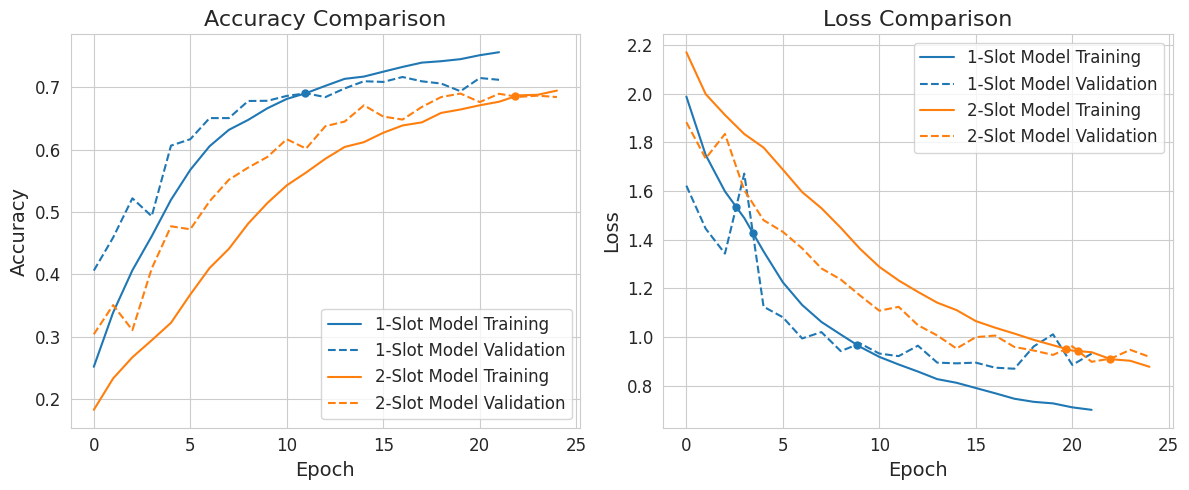

In [35]:
def find_crossings(x, y1, y2):
    """Find crossing points between two curves using linear interpolation."""
    crossings = []
    for i in range(1, len(x)):
        if (y1[i-1] - y2[i-1]) * (y1[i] - y2[i]) < 0:
            x0, x1 = x[i-1], x[i]
            y1_0, y1_1 = y1[i-1], y1[i]
            y2_0, y2_1 = y2[i-1], y2[i]

            slope1 = (y1_1 - y1_0) / (x1 - x0)
            slope2 = (y2_1 - y2_0) / (x1 - x0)
            if slope1 == slope2:
                continue
            x_cross = x0 + (y2_0 - y1_0) / (slope1 - slope2)
            y_cross = y1_0 + slope1 * (x_cross - x0)
            crossings.append((x_cross, y_cross))
    return crossings
    
def create_subplot(position, metric, title, ylabel, results):
    """
    Creates a subplot comparing training and validation curves for a given metric 
    (e.g., accuracy or loss) across multiple models.
    """
    plt.subplot(1, 2, position)
    for i, res in enumerate(results):
        color = color_map[res['name']]
        train_vals = np.array(res['history'][metric])
        val_vals = np.array(res['history'][f'val_{metric}'])
        epochs = np.arange(len(train_vals))

        plt.plot(epochs, train_vals, color=color, label=f'{res["name"]} Training')
        plt.plot(epochs, val_vals, '--', color=color, label=f'{res["name"]} Validation')

        if i < 2:
            crossings = find_crossings(epochs, train_vals, val_vals)
            plt.plot(*zip(*crossings), 'o', color=color, markersize=5)

    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Epoch')
    plt.legend()

colors = plt.cm.tab10.colors
color_map = {res['name']: colors[i % len(colors)] for i, res in enumerate(results)}
plt.figure(figsize=(12, 5))

create_subplot(1, 'accuracy', 'Accuracy Comparison', 'Accuracy', results)
create_subplot(2, 'loss', 'Loss Comparison', 'Loss', results)

plt.tight_layout()
plt.show()

# Reference

- [Learning Multiple Layers of Features from Tiny Images](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf), Alex Krizhevsky, 2009.